<a href="https://colab.research.google.com/github/law0/face_detect/blob/main/face_detect_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
req = """# Python 3.7.5
onnx>=1.7.0
numpy>=1.19.1

torch>=1.8.1
torchvision>=0.9.1

tensorflow>=2.1.0
tensorflow-gpu>=2.1.0"""

f = open("requirements.txt", "w")
f.write(req)
f.close()

In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 804.1 MB 1.7 kB/s  eta 0:00:01     |██████████▏                     | 256.0 MB 68.7 MB/s eta 0:00:08     |██████████▎                     | 257.4 MB 68.7 MB/s eta 0:00:08     |██████████▎                     | 258.9 MB 68.7 MB/s eta 0:00:08     |██████████▍                     | 261.9 MB 68.7 MB/s eta 0:00:08     |██████████████▋                 | 366.3 MB 41.0 MB/s eta 0:00:11     |██████████████▋                 | 367.8 MB 41.0 MB/s eta 0:00:11     |██████████████▊                 | 369.3 MB 41.0 MB/s eta 0:00:11     |███████████████▎                | 382.7 MB 41.0 MB/s eta 0:00:11     |████████████████                | 400.0 MB 36.2 MB/s eta 0:00:12     |██████████████████████████      | 653.6 MB 37.7 MB/s eta 0:00:04     |██████████████████████████▋     | 668.2 MB 71.3 MB/s eta 0:00:02     |█████████████████████████████   | 729.6 MB 66.8 MB/s eta 0:00:02     |███████████████████████████████▌| 790.9 MB 60.2 MB/s eta 0:00:01
     |█████████████

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import widerface
import tensorflow_datasets.public_api as tfds
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import os
import copy
import pandas
import requests
import zipfile
from math import ceil
from math import floor
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.1+cu102
Torchvision Version:  0.9.1+cu102


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.manual_seed(1)

In [ ]:
batch_size_train = 5
batch_size_val = 1
batch_size_test = 1
num_classes = 1
num_cells = 49
num_boxes_per_cell = 4
img_dim = 224
epochs = 5

def detection_collate(batch):
    """Custom collate fn for dealing with batches of images that have a different
    number of associated object annotations (bounding boxes).
    Arguments:
      batch: (tuple) A tuple of tensor images and lists of annotations
    Return:
      A tuple containing:
          1) (tensor) batch of images stacked on their 0 dim
          2) (list of tensors) annotations for a given image are stacked on 0 dim
    """
    transform_resize = transforms.Resize((img_dim, img_dim))
    targets = []
    imgs = []
    for _, sample in enumerate(batch):
        img, annot = sample
        target = torch.tensor(annot['bbox']).float()
        if target.shape[0] < 11: #drop images with too many targets : too hard
            orig_h = img.shape[1]
            orig_w = img.shape[2]
            img = transform_resize(img)

            target[:,0] = target[:,0] / orig_w * img_dim
            target[:,2] = target[:,2] / orig_w * img_dim

            target[:,1] = target[:,1] / orig_h * img_dim
            target[:,3] = target[:,3] / orig_h * img_dim

            mt = torch.mean(target, dim=0)
            if mt[2] * mt[3] > 400: # drop images with too small targets (w*h < 20*20)
                imgs.append(img)
                targets.append(target)

    imgs_t = None
    targets_t = None
    if len(imgs) > 0 and len(targets) > 0:
        imgs_t = torch.stack(imgs, 0)
        targets_t = targets

    return (imgs_t, targets_t)

In [ ]:
#widerface_path = '/kaggle/input/'
widerface_path = './'
train_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace(widerface_path, "train", download=False,
                             transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_train, shuffle=True, collate_fn=detection_collate)

val_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace(widerface_path, "val", download=True,
                              transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_val, shuffle=True, collate_fn=detection_collate)

test_loader = torch.utils.data.DataLoader(
  datasets.WIDERFace(widerface_path, "test", download=True,
                             transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                             ])),
  batch_size=batch_size_test, shuffle=True, collate_fn=detection_collate)



Files already downloaded and verified
Files already downloaded and verified


79.40625 49.4196662902832 19.25 54.25419616699219
120.3125 47.27098083496094 17.71875 53.71702575683594
132.5625 29.007192611694336 13.5625 40.8249397277832


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


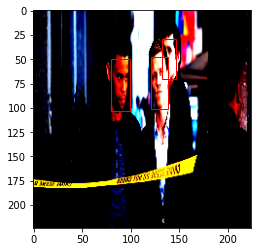

In [ ]:
images = None
targets = None

while images is None or targets is None:
    images, targets = next(iter(train_loader))

fig, ax = plt.subplots()

ax.imshow(images[0].permute(1, 2, 0))

num_targets = targets[0].shape[0]
for i in range(num_targets):
    #x,y represent bottom left corner
    x = targets[0][i][0]
    y = targets[0][i][1]
    w = targets[0][i][2]
    h = targets[0][i][3]
    print("{} {} {} {}".format(x, y, w, h))
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

In [ ]:
def intersect(box_a, box_b):
    """ 
    We compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """

    max_xy = torch.min(box_a[:, 2:] + box_a[:, :2], box_b[:, 2:] +  box_b[:, :2])
    min_xy = torch.max(box_a[:, :2], box_b[:, :2])

    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Pred box Shape: [4]
    Return:
        
    """
    inter = intersect(box_a, box_b)
    area_a = box_a[:, 2] * box_a[:, 3]  # [A,B]
    area_b = box_b[:, 2] * box_b[:, 3]  # [A,B]
    union = area_a + area_b - inter
    return inter / (union + 1e-10)  # [A,B]

In [ ]:
def index_select_2D(input, dim, indexes, by=1):
    """
        like index_select but with indexes with more than one dim
        example :
          x=torch.randn((2,3,2))
          i = torch.randint(2, (2,3,1))
          index_select_2D(x, -1, i)
          will select in the last dimension (2) with the value in i
          and output a tensor of shape (2, 3)

          x=torch.randn((2,3,2,4))
          i = torch.randint(2, (2,3,1))
          index_select_2D(x, -2, i, by=4)
          will select (whole row, 4 by 4) along the dimension (2) with the value in i
          and output a tensor of shape (2, 3, 4)

          NOTE : indexes must have the same number of dimension as input
      """
    if by > 1:
        indexes = torch.stack([indexes]*by, dim=-1)
    return torch.gather(input, dim, indexes).squeeze(2)


In [ ]:
class ResnetGrid7x7(nn.Module):
    def __init__(self, resnet=models.resnet18(pretrained=True)):
        super(ResnetGrid7x7, self).__init__()
        self.resnet = resnet
        self.resnet.fc = nn.Linear(512, num_cells*(num_classes+num_boxes_per_cell*5)) # 7 * 7 * (class + 2 * (x,y,w,h + confidence))
        self.sigmo = nn.Sigmoid()

    def forward(self, x):
        return self.sigmo(self.resnet(x))
    
    def train(self, mode: bool=True):
        self.resnet.train(mode)

    def eval(self):
        self.resnet.eval()

    def freeze_resnet(self, mode: bool=True):
        for param in self.resnet.parameters():
            param.require_grad = not mode


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
class PseudoYolo7x7Loss(nn.Module):
    def __init__(self, noobj_w=1.0, class_w=1.0, conf_w=1.0, box_w=1.0):
        super(PseudoYolo7x7Loss, self).__init__()
        self.class_w = class_w
        self.conf_w = conf_w
        self.box_w = box_w
        self.noobj_w = noobj_w
        self.sse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()

        #Coords of each cells
        self.cell_x = torch.empty(num_cells).int().to(device)
        self.cell_y = torch.empty(num_cells).int().to(device)
        for i in range(num_cells):
            self.cell_x[i] = floor(i % 7) * 32
            self.cell_y[i] = floor(i / 7) * 32


    def getResponsibleCells(self, targets):
        """  
        return a tuple of tensor:
        - is_responsible, of size (batch_size, num_targets, num_cells)
          which contain the target confidence (0 or 1) for each cell (basically if
          the cell is responsible of at least one target bounding box, it will have a 1)
        - targets_box of size (batch_size, num_cells, 4)
          which contains for each cell, the target bounding box it is responsible of
        """

        batch_size = len(targets)

        # This limit the number of,  detectable targets to the first 10 targets
        num_lim_targets = 10
        lim_targets = - torch.ones(batch_size, num_lim_targets, 4).float().to(device)
        for b in range(batch_size):
            num_targets = targets[b].shape[0]
            # even with overflow index, pytorch doesn't error, good
            lim_targets[b, :num_targets] = targets[b][:num_lim_targets]

        # Calculates centers of target boxes
        center_xs = lim_targets[:, :, 0] + lim_targets[:, :, 2]/2
        center_ys = lim_targets[:, :, 1] + lim_targets[:, :, 3]/2
        # make it broadcastable with cell_x and cell_y
        center_xs = center_xs.unsqueeze(2).expand(-1, -1, num_cells)
        center_ys = center_ys.unsqueeze(2).expand(-1, -1, num_cells)

        # is_responsible contains for each targets (rows) if cells is responsible (columns)
        is_responsible_x = torch.logical_and(self.cell_x <= center_xs, center_xs <= self.cell_x + 32)
        is_responsible_y = torch.logical_and(self.cell_y <= center_ys, center_ys <= self.cell_y + 32)
        is_responsible = torch.logical_and(is_responsible_x, is_responsible_y)  

        # https://pytorch.org/docs/stable/generated/torch.nonzero.html
        batch_indexes,target_indexes,cell_indexes = is_responsible.nonzero(as_tuple=True)

        #resize to range [0. 1.]
        lim_targets = lim_targets / img_dim

        # batch_size * (49 rows of (.5,.5,.5,.5))
        targets_boxes = torch.tensor((.5,.5,.5,.5)).expand((batch_size, num_cells, 4)).to(device)
        # Pytorch indexing is just magical...
        targets_boxes[batch_indexes, cell_indexes, :] = lim_targets[batch_indexes, target_indexes, :]

        #(batch_size, num_targets, num_cells) (batch_size, num_cells, 4)
        return is_responsible, targets_boxes

    def prepareBoxes(self, preds_boxes, targets_boxes):
        preds_boxes_xy, preds_boxes_wh = torch.split(preds_boxes, 2, dim=-1)
        targets_boxes_xy, targets_boxes_wh = torch.split(targets_boxes, 2, dim=-1)

        # predict box center_x, center_y relative to cell_x, and cell_y
        cell_xy = torch.stack([self.cell_x, self.cell_y], dim=-1)
        targets_centers = (targets_boxes_xy + targets_boxes_wh / 2.)
        targets_boxes_xy =  targets_centers - cell_xy / img_dim

        # predict square root of w and h. Otherwise loss function would advantage
        # small boxes
        preds_boxes_wh = preds_boxes_wh.sqrt()
        targets_boxes_wh = targets_boxes_wh.sqrt()

        # reunite
        preds_boxes = torch.cat([preds_boxes_xy, preds_boxes_wh], dim=-1)
        targets_boxes = torch.cat([targets_boxes_xy, targets_boxes_wh], dim=-1)

        return preds_boxes, targets_boxes

    def sseLoss(self, preds, targets, weights=1.0):
        return torch.sum(weights * ((preds - targets) * (preds - targets)), dim=1).mean()

    def forward(self, predictions, targets):
        preds = predictions.view(-1, num_cells, num_classes+num_boxes_per_cell*5)
        batch_size = preds.shape[0]

        # (batch, cells, (class + boxes * (x,y,w,h + confidence))
        preds_class = preds[:,:,0] #(batch, cells, class(1))
        preds_conf_and_boxes = preds[:,:,1:].view(-1, num_cells, num_boxes_per_cell, 5)
        preds_confs = preds_conf_and_boxes[:, :, :, 0] #(batch, cells, boxes)
        preds_boxes = preds_conf_and_boxes[:, :, :, 1:] #(batch, cells, boxes, 4)

        # print("A ", preds_confs.shape, preds_boxes.shape)

        is_responsible, targets_boxes = self.getResponsibleCells(targets)

        ious = []
        for i in range(num_boxes_per_cell):
            pb = preds_boxes[:,:,i,:]
            iou_bi = jaccard(targets_boxes.view(-1, 4), pb.contiguous().view(-1, 4))
            iou_bi = iou_bi.view(targets_boxes.shape[0], targets_boxes.shape[1]) #(batch, cells)
            ious.append(iou_bi)
        iou = torch.stack(ious, dim=-1) #(batch, cells, boxes)

        max_iou_indexes = torch.argmax(iou, dim=-1, keepdim=True)

        # print("max ", max_iou_indexes.shape)

        # For each cell, select the box and conf with max IoU
        preds_confs = index_select_2D(preds_confs, -1, max_iou_indexes)
        preds_boxes = index_select_2D(preds_boxes, -2, max_iou_indexes, by=4)

        # print("B ", preds_confs.shape, preds_boxes.shape)

        # w, h are to be evaluated to their sqrt (advantages little boxes otherwise)
        # preds x, y are to be evaluated as center of box and relative to the cell x,y
        preds_boxes, targets_boxes = self.prepareBoxes(preds_boxes, targets_boxes)

        # calculate box loss only for if a the cell is responsible. This zeros the loss otherwise
        ir_reduced = (torch.sum(is_responsible, 1) > 0).float().detach()
        #targets_boxes.masked_scatter_(torch.logical_not(cr_reduced.bool()).unsqueeze(-1).expand_as(targets_boxes),
        #                              preds_boxes)

        # If an object is not detected, weight down the conf loss
        noobj_w = (1 - ir_reduced) * self.noobj_w + ir_reduced
        box_noobj_w = ir_reduced.unsqueeze(-1).expand(-1, 49, 4)
        coonf_noobj_w = ir_reduced
                
        class_loss = self.class_w * self.sseLoss(preds_class, ir_reduced, noobj_w)
        box_loss = self.box_w * self.sseLoss(preds_boxes, targets_boxes, box_noobj_w)
        conf_loss = self.conf_w * self.sseLoss(preds_confs, ir_reduced, coonf_noobj_w)


        return class_loss + box_loss + conf_loss

In [ ]:
model = ResnetGrid7x7()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=5e-4)
criterion = PseudoYolo7x7Loss(noobj_w=0.5, box_w=5.0, conf_w=0.5, class_w=1.0)

------------------------------- epoch  0  --------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


7.6227
mean 0.4952792525291443, min 0.161714106798172, max 0.8109354972839355


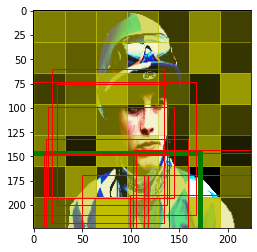

0.7443
mean 0.04719538614153862, min 0.013115771114826202, max 0.22009217739105225


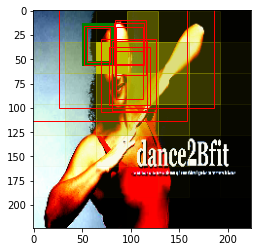

1.1064
mean 0.0571148581802845, min 0.00937441736459732, max 0.637852668762207


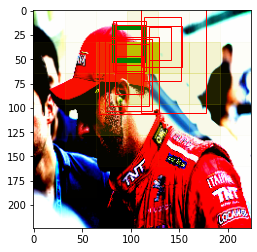

1.3713
mean 0.07460340112447739, min 0.00858305487781763, max 0.3711948096752167


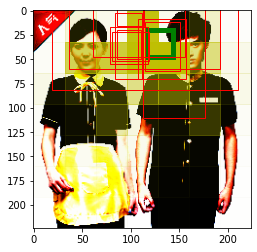

0.6847
mean 0.08574781566858292, min 0.006763129960745573, max 0.43206119537353516


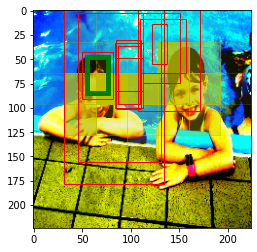

2.1848
mean 0.10085040330886841, min 0.01356429886072874, max 0.6423662304878235


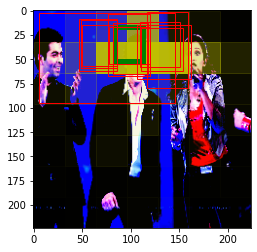

------------------------------- epoch  1  --------------------------------
0.7554
mean 0.05895260348916054, min 0.005781813990324736, max 0.41636279225349426


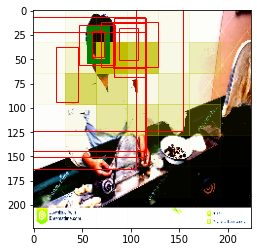

0.7444
mean 0.046403564512729645, min 0.005332514178007841, max 0.36889341473579407


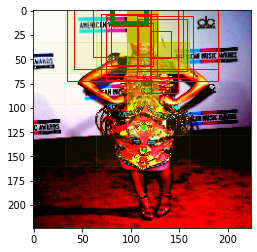

1.2078
mean 0.08252496272325516, min 0.007761718239635229, max 0.8562890291213989


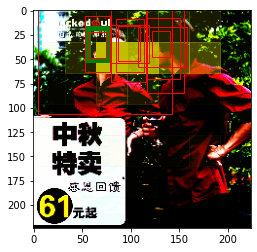

0.4669
mean 0.052784524857997894, min 0.0026396308094263077, max 0.6206309199333191


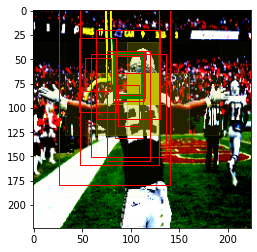

1.0305
mean 0.04677414149045944, min 0.0024424176663160324, max 0.5841002464294434


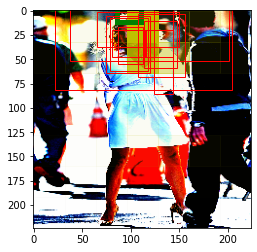

0.8782
mean 0.04942406341433525, min 0.005386306904256344, max 0.32514476776123047


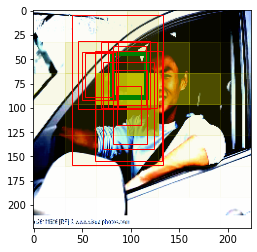

------------------------------- epoch  2  --------------------------------
0.6589
mean 0.06326990574598312, min 0.005369564983993769, max 0.7182876467704773


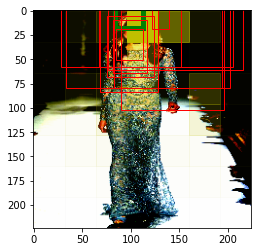

0.8838
mean 0.06884792447090149, min 0.005823884624987841, max 0.8644728064537048


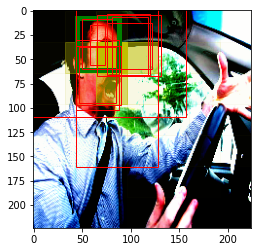

0.2900
mean 0.052183885127305984, min 0.005331763066351414, max 0.651330292224884


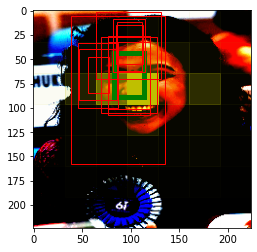

2.1303
mean 0.04249515384435654, min 0.005777531303465366, max 0.4194977581501007


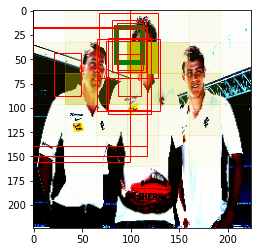

0.8146
mean 0.041908588260412216, min 0.002076638862490654, max 0.9048909544944763


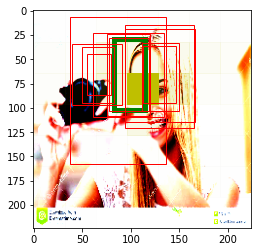

0.4866
mean 0.048514578491449356, min 0.0054429625160992146, max 0.3922324478626251


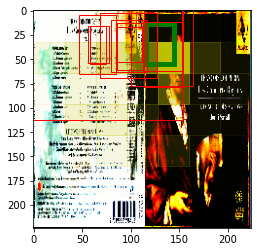

------------------------------- epoch  3  --------------------------------
0.4214
mean 0.06421048194169998, min 0.005552599672228098, max 0.876319408416748


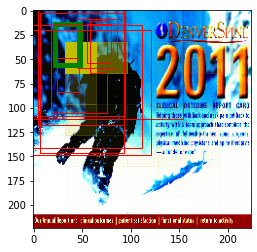

0.6720
mean 0.08432884514331818, min 0.011113552376627922, max 0.8753365278244019


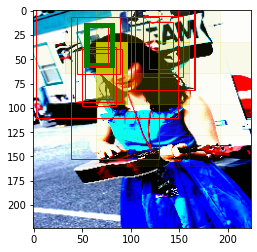

1.3712
mean 0.05105234682559967, min 0.004078157711774111, max 0.9484979510307312


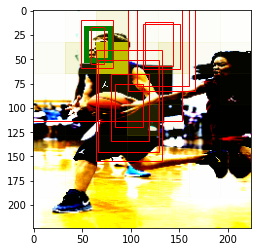

0.7633
mean 0.11878488212823868, min 0.004019384738057852, max 0.8629500269889832


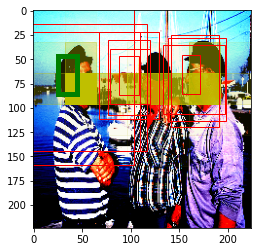

0.9716
mean 0.0730176568031311, min 0.005935144145041704, max 0.7144759297370911


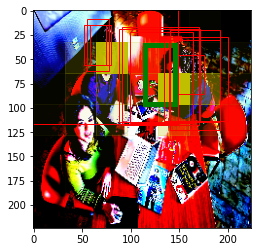

0.7368
mean 0.050535108894109726, min 0.004501511342823505, max 0.4026276171207428


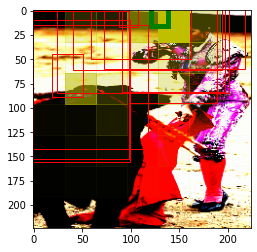

------------------------------- epoch  4  --------------------------------
0.1801
mean 0.08600489795207977, min 0.00711209187284112, max 0.9194873571395874


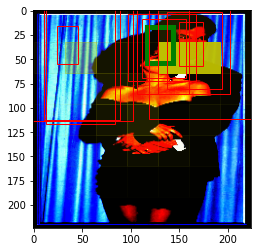

2.7202
mean 0.10738430917263031, min 0.006278563290834427, max 0.8673332929611206


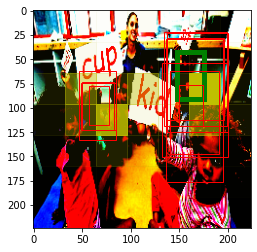

0.2984
mean 0.08305852860212326, min 0.00330449640750885, max 0.9619268178939819


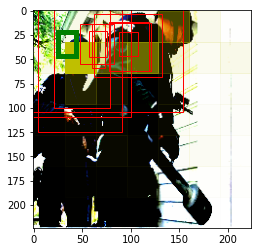

0.7995
mean 0.0521601177752018, min 0.004254855681210756, max 0.7379747629165649


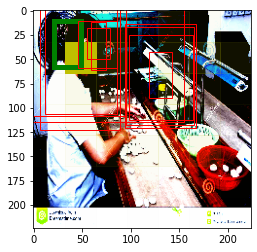

0.0703
mean 0.0549556165933609, min 0.005228293593972921, max 0.9705125689506531


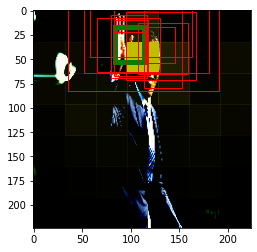

0.6129
mean 0.1197594702243805, min 0.005091152153909206, max 0.9648945331573486


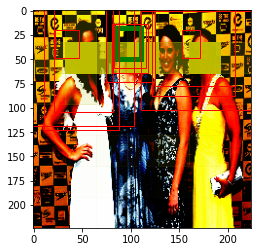

In [ ]:
loss_over_time = []

model.to(device)
model.train(True)

images = None
targets = None
t = []

#while images is None or targets is None:
#    images, targets = next(iter(train_loader))
#    t.append((images, targets))
    
#images = None
#targets = None
    
#while images is None or targets is None:
#    images, targets = next(iter(train_loader))
#    t.append((images, targets))
time_start = time.time()
for ep in range(epochs):
    if time.time() - time_start > 3 * 60 * 60:
        break
    print("------------------------------- epoch ", ep, " --------------------------------")
    for i, (images, targets) in enumerate(train_loader):
    #for i, (images, targets) in enumerate(t * 1000):
        if images is None or targets is None:
            continue
        images = images.to(device)
        targets = [anno.to(device) for anno in targets]

        optimizer.zero_grad()

        out = model(images)
        loss = criterion(out, targets)
        loss.backward()
        optimizer.step()

        if i % 500 == 0:
        #if i > 997:
            loss = loss.cpu()
            print("{:.4f}".format(loss.item()))
            loss_over_time.append(loss.item())

        #if i % 100 == 0:
            preds = out.view(-1, num_cells, num_classes+num_boxes_per_cell*5)
            classes = preds[0,:,0]
            conf_and_boxes = preds[0, :, 1:]

            min_class = torch.min(classes).item()
            max_class = torch.max(classes).item()
            range_class = max_class - min_class
            
            print("mean {}, min {}, max {}".format(classes.mean().item(), min_class, max_class))

            max_class_indexes = torch.argsort(classes, descending=True)

            fig, ax = plt.subplots()
            im = images[0].permute(1, 2, 0).cpu()
            ax.imshow(im)

            rects = []

            for c in range(49):
                cell = max_class_indexes[c]
                cell_pred = conf_and_boxes[cell, :].view(num_boxes_per_cell, 5)
                cell_x = floor(cell % 7) * 32
                cell_y = floor(cell / 7) * 32

                # color responsible cell
                rect = patches.Rectangle((cell_x, cell_y), 32, 32, linewidth=1, edgecolor='y', facecolor='y', fill=True, 
                                         alpha=((classes[cell] - min_class) / range_class).item())
                ax.add_patch(rect)

                if c < 3:
                    for b in range(num_boxes_per_cell):
                        conf = cell_pred[b, 0] #(boxes, 1)
                        box = cell_pred[b, 1:] #(boxes, 4)

                        w = box[2] * img_dim
                        h = box[3] * img_dim
                        x = box[0] * 32 + cell_x - w / 2.
                        y = box[1] * 32 + cell_y - h / 2.

                        #print("class {}, confidence {}, box: {} {} {} {}".format(classes[cell].item(), conf.item(), x, y, w, h))
                        rects.append((x, y, w, h, classes[cell].item() * conf.item()))
                    
            rects = sorted(rects, key=lambda t: t[4], reverse=True)

            if len(rects) > 0:
                # most confident in green
                rect = patches.Rectangle((rects[0][0], rects[0][1]), rects[0][2], rects[0][3], linewidth=5, edgecolor='g', facecolor='none')
                ax.add_patch(rect)

                # rest in red
                for i in range(1, len(rects)):
                    rect = patches.Rectangle((rects[i][0], rects[i][1]), rects[i][2], rects[i][3], linewidth=1, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)     

            plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


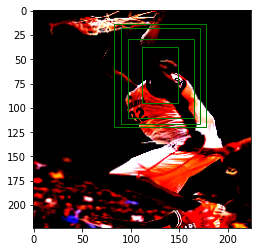

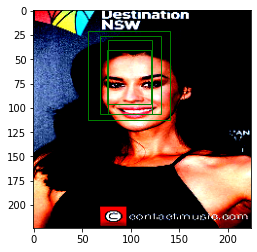

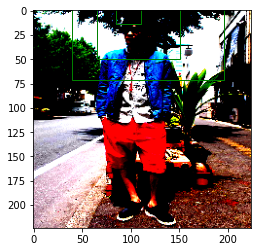

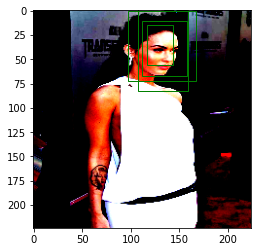

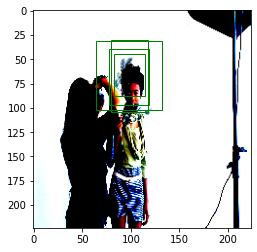

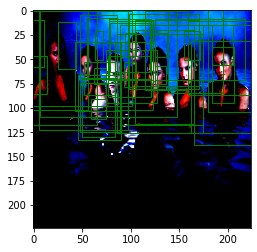

In [ ]:
model.train(False)
model.eval()

for i, (images, targets) in enumerate(val_loader):
    if images is None or targets is None:
        continue
    images = images.to(device)
    targets = [anno.to(device) for anno in targets]

    out = model(images)

    preds = out.view(-1, num_cells, num_classes+num_boxes_per_cell*5)
    for b in range(preds.shape[0]): # batch
        classes = preds[b,:,0]
        conf_and_boxes = preds[b, :, 1:].view(num_cells, num_boxes_per_cell, 5)

        fig, ax = plt.subplots()
        im = images[b].permute(1, 2, 0).cpu()
        ax.imshow(im)

        for c in range(49): # cell
            classe = classes[c]
            cell_x = floor(c % 7) * 32
            cell_y = floor(c / 7) * 32
            if classe > 0.5:
                for bc in range(num_boxes_per_cell): # boxes
                    conf = conf_and_boxes[c, bc, 0]
                    box = conf_and_boxes[c, bc, 1:]

                    if conf > 0.5:                    
                        w = box[2] * img_dim
                        h = box[3] * img_dim
                        x = box[0] * 32 + cell_x - w / 2.
                        y = box[1] * 32 + cell_y - h / 2.

                        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
                        ax.add_patch(rect)
    
    plt.show()
    if i >= 10:
        break
                            
                            
                    
                

In [ ]:
torch.save(model.state_dict(), './face_detect_resnet18_state_dict.pth')
torch.save(model, './face_detect_resnet18_whole.pth')